# Political blogs as networks in the 2004 election

#### Shovan Biswass, Randy Thompson, Ben Horvath


This notebook compares the centrality between American conservative and liberal blogs during the 2004 election.

We found that influence in the liberal blogosphere is concentrated in a few top blogs, whereas influence in the conservative blogs is more widely distributed.


First, load essential libraries:

In [6]:
import itertools
from urllib.request import urlopen

import matplotlib.pyplot as plot
import networkx as nx
from networkx.algorithms import traversal as tr
from networkx.algorithms.components import connected_components as cc
import networkx.generators.small as sm
import numpy as np
import pandas as pd
import igraph as ig

# Set plot size globally
plot.rcParams['figure.figsize'] = [10, 5]

## Load the data

Our data was collected by researchers Lada Adamic and Natalie Glance and 2005. They crawled the top political blogs of the period, saving the HTML links between them, and storing them in a machine readable format. The dataset is accessible from: http://networkdata.ics.uci.edu/data/polblogs/.

It is important to note that this network is a _directed multigraph_, which allows each node multiple directions. This makes sense: Just because blog A links to blog B, it does not follow that blog B links to blog A. This means the analysis is a bit different from an undirected graph.

In [7]:
G = nx.readwrite.read_gml("polblogs.gml")

print( len(G.nodes()), len(G.edges()) )

1490 19090


The network graph consists of 1490 political blogs, reprented as nodes, and about 19 thousand links between them (edges).

We can directly examine what these nodes look like by key. The `value` takes either 0 or 1, where 0 indicates a left or liberal blog, and 1 indicates a right or conservative blog:

In [4]:
G.nodes()['100monkeystyping.com']

{'value': 0, 'source': 'Blogarama'}

## Centrality

The first question we ask is: What blogs are most important in this network? We examine the _centrality_ of the network to answer this. Each node in the graph has a _degree_, i.e., the number of connections between it and other nodes, i.e., HTML links.

The `degree` function calculates the degree of every node in a graph, and a custom `sorted_tuple` function puts it in descending order:

In [8]:
def sorted_tuple(map):
    """ Sorts a list of (k, v) tuples by v (desc)."""
    ms = sorted(map, key = lambda kv: (-kv[1], kv[0]))
    return ms

deg = nx.degree(G)
deg_sorted = sorted_tuple(deg)
deg_sorted[:10]

[('blogsforbush.com', 468),
 ('dailykos.com', 384),
 ('instapundit.com', 363),
 ('atrios.blogspot.com', 351),
 ('talkingpointsmemo.com', 283),
 ('washingtonmonthly.com', 256),
 ('drudgereport.com', 245),
 ('powerlineblog.com', 236),
 ('michellemalkin.com', 229),
 ('hughhewitt.com', 225)]

A more sophisticated way to measure centrality is _closeness centrality_. The algorithm iterates through the network, and is an attempt to represent how central a node is to the network.

There is substantial overlap between this measure and the more primitive measure above.

In [10]:
#sorting function from SNA textbook, edited for dict object
def sorted_map(map):
    ms = sorted(map.items(), key = lambda kv: (-kv[1], kv[0]))
    return ms

# measure of node’s centrality
c = nx.closeness_centrality(G)
cs = sorted_map(c)
print(cs[:10])

[('dailykos.com', 0.3677362450836158), ('instapundit.com', 0.3514046453768085), ('talkingpointsmemo.com', 0.34605155249883257), ('atrios.blogspot.com', 0.34537268726587755), ('drudgereport.com', 0.3304621817621418), ('washingtonmonthly.com', 0.32968862796588216), ('powerlineblog.com', 0.3290723875397777), ('andrewsullivan.com', 0.323298591006189), ('nationalreview.com/thecorner', 0.32053477894179533), ('talkleft.com', 0.3138212608445295)]


We can also segment the network into its liberal and conservative blogs, and run this algorithm on each seperately:

In [12]:
# Define liberal subgraph
libs = [n for n,v in G.nodes(data=True) if v['value'] == 0]  
G_libs = G.subgraph(libs)

# Define conservative subgraph
cons = [n for n,v in G.nodes(data=True) if v['value'] == 1]  
G_cons = G.subgraph(cons)

Thus DailyKos, Atrios, and TPM are the most central liberal blogs, while Druge, Instapundit, and BlogsForBush are the most central conservative blogs:

In [13]:
# measure of node’s centrality: liberal
c_libs = nx.closeness_centrality(G_libs)
cs_libs = sorted_map(c_libs)
print(cs_libs[:10])

[('dailykos.com', 0.4370256879099083), ('atrios.blogspot.com', 0.4094114274101064), ('talkingpointsmemo.com', 0.3952937919821717), ('juancole.com', 0.34657153390064815), ('washingtonmonthly.com', 0.3410200447992648), ('talkleft.com', 0.33488934736467124), ('digbysblog.blogspot.com', 0.3300681275244268), ('pandagon.net', 0.3289751867048096), ('prospect.org/weblog', 0.3268108762659621), ('thismodernworld.com', 0.3211762059855145)]


In [14]:
# measure of node’s centrality: Conservative
c_cons = nx.closeness_centrality(G_cons)
cs_cons = sorted_map(c_cons)
print(cs_cons[:10])

[('drudgereport.com', 0.4236693780099153), ('instapundit.com', 0.4230843680004424), ('blogsforbush.com', 0.41134561096921635), ('powerlineblog.com', 0.4025044722719141), ('littlegreenfootballs.com/weblog', 0.39186558754226003), ('michellemalkin.com', 0.3892931657422014), ('hughhewitt.com', 0.3749356728012351), ('captainsquartersblog.com/mt', 0.3698689745201373), ('nationalreview.com/thecorner', 0.3683374259713997), ('lashawnbarber.com', 0.36419033110375854)]


How does centrality vary between the two political persuasions? The histogram shows that liberals have a greater portion of the distribution at zero, compared to conservatives. The conservative distribution is substantially to the right. This suggests the liberal blogosphere has greater proportion of uninfluential blogs and that influence is more heavily concentrated to a few top blogs. Whereas conservatives have a wider landscape.

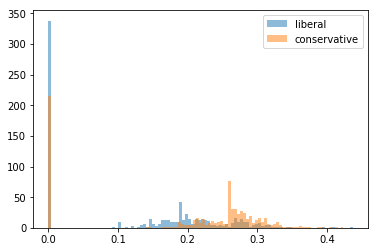

In [10]:
lib_centrality = [i[1] for i in cs_libs]
con_centrality = [i[1] for i in cs_cons]

plot.hist(lib_centrality, 100, alpha=0.5, label='liberal')
plot.hist(con_centrality, 100, alpha=0.5, label='conservative')
plot.legend(loc='upper right')

## Betweenness

Next, we are going to look at Eigenvector Centrality. This measures community bridges or boundary-spanners. This list of blogs might be considered centrist blogs since they have linkages between both liberal and conservative communities. 

In [11]:
#copy graph
Gtest = G
#set weight attribute to 1
nx.set_edge_attributes(Gtest, 1, name="weight")
#turn networkx graph into igraph graph
g = ig.Graph.TupleList(Gtest.edges(), directed=True)
#weight attribute didn't transfer so adding it again
g.es["weight"] = 1
#simplifying multigraph and removing parallel edges by summing the weights of each edge into a single edge
#in this case each weight is 1 
g.simplify(combine_edges="sum")
#turning igraph graph back into networkx graph
Gsimp = nx.from_edgelist([(names[x[0]], names[x[1]])
                      for names in [g.vs['name']] # simply a let
                      for x in g.get_edgelist()], nx.Graph())
#running eigenvector centrality
Gsimp_eg = nx.eigenvector_centrality(Gsimp)
#sorting and printing
eg_sort = sorted_map(Gsimp_eg)
print(eg_sort[:10])

[('dailykos.com', 0.1642218994937242), ('atrios.blogspot.com', 0.1605328031648251), ('talkingpointsmemo.com', 0.1492884590730164), ('washingtonmonthly.com', 0.13964832618172254), ('liberaloasis.com', 0.11899790925753914), ('digbysblog.blogspot.com', 0.11788580430662415), ('instapundit.com', 0.1133611980190733), ('bodyandsoul.typepad.com', 0.11122778589521791), ('pandagon.net', 0.10815333461885308), ('talkleft.com', 0.1074081857426938)]


In [24]:
names1=[x[0] for x in deg_sorted[:10]]
names2=[x[0] for x in cs[:10]]
names3=[x[0] for x in eg_sort[:10]]
names=list(set(names1) | set(names2) | set (names3))
table=[[name,deg[name],c[name],Gsimp_eg[name]] for name in names]
data=pd.DataFrame(table, columns = ["blog", "degrees", "closeness", "betweenness"])
data.sort_values('degrees', ascending=False)

blog  degrees  closeness  betweenness
8                  blogsforbush.com      468   0.392334     0.051799
5                      dailykos.com      384   0.425334     0.164222
10                  instapundit.com      363   0.425877     0.113361
0               atrios.blogspot.com      351   0.408668     0.160533
13            talkingpointsmemo.com      283   0.412541     0.149288
15            washingtonmonthly.com      256   0.401942     0.139648
1                  drudgereport.com      245   0.397790     0.053046
16                powerlineblog.com      236   0.389132     0.074296
7                michellemalkin.com      229   0.397001     0.068286
12                   hughhewitt.com      225   0.390955     0.068046
9                  liberaloasis.com      216   0.361196     0.118998
11  littlegreenfootballs.com/weblog      208   0.405523     0.066794
6                 truthlaidbear.com      204   0.394498     0.064120
4           digbysblog.blogspot.com      189   0.376263     0.117886
3           bodyandsoul.typepad.com      182   0.352921     0.111228
14                     pandagon.net      171   0.367831     0.108153
2                      talkleft.com      162   0.383615     0.107408